##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# tf.data API によるパフォーマンスの改善

<table class="tfo-notebook-buttons" align="left">
  <td data-parent-segment-id="13650222" data-segment-approved="false"><a target="_blank" href="https://www.tensorflow.org/guide/data_performance"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td data-parent-segment-id="13650223" data-segment-approved="false"><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td data-parent-segment-id="13650224" data-segment-approved="false"><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td data-parent-segment-id="13650225" data-segment-approved="false"><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

## 概要

GPU と TPU は、単一のトレーニングステップを実行するために必要な時間を劇的に短縮することができます。ピークパフォーマンスの達成には、現在のステップが終了する前に、次のステップのデータを配信する有効な入力パイプラインが必要となります。柔軟で効率的な入力パイプラインの構築に役立つのが、`tf.data` API です。このドキュメントでは、`tf.data` API を使用して非常に性能の高い TensorFlow 入力パイプラインを構築する方法を説明します。

読み進める前に、「[TensorFlow 入力パイプラインの構築](./data.ipynb)」ガイドに目を通し、`tf.data` API の使用方法を学習してください。

## リソース

- [TensorFlow 入力パイプラインの構築](./data.ipynb)
- `tf.data.Dataset` API
- <a>TensorFlow プロファイラを使用した <code>tf.data</code> パフォーマンスの分析</a>

## セットアップ

In [2]:
import tensorflow as tf

import time

2022-12-14 20:12:40.389570: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:12:40.389666: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:12:40.389675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


このガイドでは、データセットをイテレートし、パフォーマンスを測定します。次のようなさまざまな要因の影響により、再現可能なパフォーマンスベンチマークを作成することが困難となる場合があります。

- 現在の CPU 負荷
- ネットワークトラフィック
- キャッシュなどの複雑なメガニズム

再現可能なベンチマークを提供するために、人工的な例を構築します。

### データセット

まずは、`ArtificialDataset` という、`tf.data.Dataset` から継承するクラスを定義します。このデータセットは次のことを行います。

- `num_samples` サンプルを生成する（デフォルトは 3）
- ファイルを開くアクションをシミュレーションするために、最初のアイテムの前にしばらくスリープする
- ファイルからデータを読み込む操作をシミュレーションするために、各アイテムを生成する前にしばらくスリープする

In [3]:
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # Opening the file
        time.sleep(0.03)
        
        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            time.sleep(0.015)
            
            yield (sample_idx,)
    
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature = tf.TensorSpec(shape = (1,), dtype = tf.int64),
            args=(num_samples,)
        )

このデータセットは `tf.data.Dataset.range` に似ており、各サンプルの開始とサンプル間に一定の遅延を追加します。

### トレーニングループ

次に、データセットのイテレートにどれくらいの時間がかかるかを測定するダミーのトレーニングループを記述します。トレーニング時間がシミュレーションされます。

In [4]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

## パフォーマンスの最適化

パフォーマンスをどのように最適化できるかを示すために、`ArtificialDataset` のパフォーマンスを改善します。

### 単純なアプローチ

コツを使わずに、単純なパイプラインから始め、ありのままのデータセットをイテレートします。

In [5]:
benchmark(ArtificialDataset())

Execution time: 0.2333629889999429


内部的には、次のように実行時間が使われています。

![Prefetched](https://www.tensorflow.org/guide/images/data_performance/prefetched.svg)

プロットに、トレーニングステップの実行には、次のアクションが伴うことが示されます。

- ファイルが開いていない場合は、ファイルを開く
- ファイルからデータをフェッチする
- トレーニングにデータを使用する

ところが、このように単純な同期実装では、パイプラインがデータをフェッチしている間、モデルはアイドル状態となります。その反対に、モデルがトレーニング中である場合、入力パイプラインがアイドル状態となります。したがって、トレーニングのステップ時間は、開いて、読み取り、トレーニングする時間の和であるということになります。

次のセクションでは、この入力パイプラインに基づいて構築し、性能の高い TensorFlow 入力パイプライン設計のベストプラクティスを説明します。

### プリフェッチ

プリフェッチは、トレーニングステップの事前処理とモデルの実行に重なって行われます。モデルがトレーニングステップ `s` を実行する間、入力パイプラインはステップ `s+1` のデータを読み取っています。そうすることで、ステップ時間をトレーニングと、データの抽出にかかる時間の最大時間（和とは反対に）に減少させることができます。

`tf.data` API は、`tf.data.Dataset.prefetch` 変換を提供します。データが生成された時間をデータが消費された時間から切り離すために使用できます。具体的には、この変換は、バックグラウンドのスレッドと内部バッファを使用して、要求される前に入力データセットから要素をプリフェッチします。プリフェッチする要素の数は、単一のトレーニングステップによって消費されるバッチの数と同等（またはそれ以上）である必要があります。この値を手動で調整するか、`tf.data.AUTOTUNE` に設定することができますが、後者の場合、`tf.data` ランタイムによって、ランタイム時に動的に値が調整されます。

プリフェッチ変換は、「プロデューサ」の作業と「コンシューマ」の作業をオーバーラップする機会があればいつでもオーバーラップさせることに注意してください。

In [6]:
benchmark(
    ArtificialDataset()
    .prefetch(tf.data.AUTOTUNE)
)

Execution time: 0.23058086499997898


![Sequential interleave](https://www.tensorflow.org/guide/images/data_performance/sequential_interleave.svg)

次に、サンプル 0 でトレーニングセットアップが実行している間、入力パイプラインはサンプル 1 のデータを読み取っているのがわかります。

### データ抽出の並列化

実世界の状況では、入力データはリモート（Google Cloud Storage や HDFS など）に保管されていることがあります。ローカルとリモートのストレージには、次のような違いがあるため、ローカルでのデータ読み取りに適したデータセットパイプラインは、リモートで読み取られる際にボトルネックとなる可能性があります。

- **最初のバイトまでの時間:** リモートストレージからファイルの最初のバイトを読み取る場合、ロカールストレージからよりもずっと長い時間がかかります。
- **読み取りのスループット:** リモートストレージの総帯域幅は一般的に大きいため、単一のファイルの読み取りには、この帯域幅のほんのわずかしか使用されません。

さらに、生のバイトがメモリに読み込まれると、データのデシリアライズや復号化する必要も出てくるため（[protobuf](https://developers.google.com/protocol-buffers/) など）、さらに計算が必要となります。このオーバーヘッドは、データの格納場所がローカルであるかリモートであるかに関係なく存在しますが、データのプリフェッチが効果的に行われない場合、リモートの場合に大きくなることがあります。

データ抽出にまつわるさまざまなオーバーヘッドの影響を緩和するために、`tf.data.Dataset.interleave` 変換を使用して、データの読み込みステップをほかのデータセットのコンテンツ（データファイルリーダーなど）とインターリーブしながら並列化することができます。オーバーラップするデータセットの数は、`cycle_length` 引数で指定し、並列化のレベルは `num_parallel_calls` 引数で指定することができます。`prefetch` 変換と同様に、`interleave` 変換も `tf.data.AUTOTUNE` をサポートしているため、どのレベルの並列化を使用するかという判断は `tf.data` ランタイムに委ねられます。

#### 順次インターリーブ

`tf.data.Dataset.interleave` 変換のデフォルトの引数によって、2 つのデータセットからの単一のサンプルが順次、インターリブされます。

In [7]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(lambda _: ArtificialDataset())
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Execution time: 0.4100713720000613


![Parallel interleave](https://www.tensorflow.org/guide/images/data_performance/parallel_interleave.svg)

この図は、`interleave` 変換の動作を示しており、利用できる 2 つのデータセットからサンプルが交互にフェッチされています。ただし、ここでは、パフォーマンスの改善は認められません。

#### 並列インターリーブ

では、`interleave` 変換の `num_parallel_calls` 引数を使用してみましょう。これは、複数のデータセットを並列して読み込むため、ファイルが開かれるまでの待機時間が短縮されます。

In [8]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        lambda _: ArtificialDataset(),
        num_parallel_calls=tf.data.AUTOTUNE
    )
)

Execution time: 0.31014879800000017


![Sequential mapping](https://www.tensorflow.org/guide/images/data_performance/sequential_map.svg)

今度は、データ実行時間のプロットからわかるように、2 つのデータセットの読み取りが並列化され、総合的なデータ処理時間が短縮されています。

### データ変換の並列化

データを準備する際、入力要素を事前処理する必要がある場合があります。この目的により、`tf.data` API は、ユーザー定義関数を入力データセットの各要素に適用する `tf.data.Dataset.map` 変換を提供しています。入力要素は互いに独立しているため、複数の CPU コアで事前処理を並列化することができます。これを行うために、`prefetch` と `interleave` 変換と同様に、`map` 変換でも `num_parallel_calls` 引数によって並列化のレベルを指定することができます。

`num_parallel_calls` 引数に最適な値を選択するには、ハードウェア、トレーニングデータの特性（サイズや形状など）、マップ関数のコスト、および CPU で同時に発生しているほかの処理を考慮する必要があります。簡単な調べ方は、利用可能な CPU コアの数を使用することですが、`prefetch` と `interleave` 変換に関して言えば、`map` 変換は `tf.data.AUTOTUNE` をサポートしているため、どのレベルの並列化を使用するかという判断は `tf.data` ランタイムに委ねられています。

In [9]:
def mapped_function(s):
    # Do some hard pre-processing
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s

#### 順次マッピング

基本の例として、並列化を使用せずに `map` 変換を使用することから始めてみましょう。

In [10]:
benchmark(
    ArtificialDataset()
    .map(mapped_function)
)

Execution time: 0.4240529329999845


![Sequential mapping](https://www.tensorflow.org/guide/images/data_performance/sequential_map.svg)

[単純なアプローチ](#The-naive-approach)について言えば、ステップを開いて読み取り、事前処理（マッピング）を行ってトレーニングする時間が、単一のイテレーションの総和となります。

#### 並列マッピング

では、同じ事前処理関数を使用して、複数のサンプルで並列に適用してみましょう。

In [11]:
benchmark(
    ArtificialDataset()
    .map(
        mapped_function,
        num_parallel_calls=tf.data.AUTOTUNE
    )
)

Execution time: 0.30054549199996927


![Parallel mapping](https://www.tensorflow.org/guide/images/data_performance/parallel_map.svg)

データプロットが示すように、事前処理ステップがオーバーラップしたことで、単一のイテレーションにかかる総合時間が短縮されたことがわかります。

### キャッシング

`tf.data.Dataset.cache` 変換は、メモリまたはローカルストレージのいずれかに、データセットをキャッシュすることができるため、各エポック中に一部の操作（ファイルを開いてデータを読み取るなど）が実行されなくなります。

In [12]:
benchmark(
    ArtificialDataset()
    .map(  # Apply time consuming operations before cache
        mapped_function
    ).cache(
    ),
    5
)

Execution time: 0.3522251550000419


![Prefetched](https://www.tensorflow.org/guide/images/data_performance/prefetched.svg)

ここでは、データ実行時間プロットは、データセットをキャッシュすると、`cache` 1 の前の変換（ファイルを開いてデータを読み取るなど）は、最初のエポックにのみ実行されることを示しています。次のエポックは、`cache` 変換によってキャッシュされたデータを再利用するようになります。

`map` 変換に渡されるユーザー定義関数が高くつく場合は、`map` 変換の後に `cache` 変換を適用することができますが、これは、キャッシュされるデータセットがメモリやローカルストレージにまだ格納できる場合に限ります。ユーザー定義関数によってデータセットを格納するために必要な容量がキャッシュのキャパシティを超えるほど増加する場合は、`cache` 変換の後に適用するようにするか、トレーニングジョブの前にデータを事前処理することでリソースの使用率を抑えることを検討してください。

### マッピングのベクトル化

`map` 変換に渡されたユーザー定義関数を呼び出すと、ユーザー定義関数のスケジューリングと実行に関連するオーバーヘッドが生じます。ユーザー定義関数をベクトル化し（1 つの入力バッチでまとめて操作させる）、`map` 変換の*前*に `batch` 変換を適用してください。

これに適した実践を示すには、artificial データセットは適していません。スケジューリングの遅延は約 10 マイクロ秒（10e-6 秒）であり、`ArtificialDataset` で使用される数十ミリ秒よりはるかに短いため、その影響がわかりづらいからです。

この例では、基本の `tf.data.Dataset.range` 関数を使用し、トレーニングループを最も単純な形態まで単純化します。

In [13]:
fast_dataset = tf.data.Dataset.range(10000)

def fast_benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in tf.data.Dataset.range(num_epochs):
        for _ in dataset:
            pass
    tf.print("Execution time:", time.perf_counter() - start_time)
    
def increment(x):
    return x+1

#### スカラマッピング

In [14]:
fast_benchmark(
    fast_dataset
    # Apply function one item at a time
    .map(increment)
    # Batch
    .batch(256)
)

Execution time: 0.24833615400007147


![Scalar map](https://www.tensorflow.org/guide/images/data_performance/scalar_map.svg)

上の図は、何が起きているかを示しています（より少ないサンプル数で）。マッピングされた関数が各サンプルに適用されているのがわかります。この関数は非常に高速ですが、時間パフォーマンスに影響するオーバーヘッドがあります。

#### ベクトル化されたマッピング

In [15]:
fast_benchmark(
    fast_dataset
    .batch(256)
    # Apply function on a batch of items
    # The tf.Tensor.__add__ method already handle batches
    .map(increment)
)

Execution time: 0.03465816100003849


![Vectorized map](https://www.tensorflow.org/guide/images/data_performance/vectorized_map.svg)

今度は、マッピングされた関数は一度だけ呼び出され、サンプルのバッチに適用されています。データ実行時間のプロットが示すように、関数の実行にかかる時間は長くなりますが、オーバーヘッドの発生は一度だけであり、総合的な時間パフォーマンスが改善されています。

### メモリフットプリントの縮小

`interleave`、`prefetch`、および `shuffle` といった多数の変換は、要素の内部バッファにとどまります。`map` 変換に渡されるユーザー定義関数が要素のサイズを変更すると、map 変換の順序付けと、要素をバッファリングする変換によって、メモリ使用率に影響が及びます。通常、パフォーマンスの目的でほかの順序が求められない限り、メモリフットプリントがより少なくなる順序を選択してください。

#### 部分計算のキャッシング

メモリに入りきれないほどのデータに増加する場合を除き、`map` 変換の後にデータセットをキャッシュすることが推奨されます。マッピングされた関数を、時間を消費するものとメモリを消費するものの 2 つに分割できれば、トレードオフを解消することができます。この場合、次のように変換をつなぐことができます。

```python
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

こうすることで、時間を消費する部分は最初のエポック中にのみ実行されるようになるため、キャッシュスペースを使いすぎなくて済みます。

## ベストプラクティスのまとめ

性能の高い TensorFlow 入力パイプライン設計のベストプラクティスをまとめてましょう。

- [`prefetch` 変換を使用](#Pipelining)して、プロデューサとコンシューマの作業をオーバーラップさせる。
- <code>interleave</code> 変換を使用して、<a>データの読み取り変換を並列化</a>する。
- <code>num_parallel_calls</code> 引数を設定して、<a><code>map</code> 変換を並列化</a>する。
- [`cache` 変換を使用](#Caching)して、最初のエポック中にデータをメモリにキャッシュする。
- `map` 変換に渡される[ユーザー定義関数をベクトル化](#Map-and-batch)する。
- <code>interleave</code>、`prefetch`、および `shuffle` 変換を適用する際に、<a>メモリ使用率を低減</a>する。

## 数値の再現

注意: これ以降のノートブックでは、上記の数値を再現する方法を説明しています。このコードを自由に調整してかまいませんが、このチュートリアルの要点ではないことに留意してください。

`tf.data.Dataset` API の理解をさらに深めるには、独自のパイプラインで調整を試すのがよいでしょう。以下は、このガイドの画像を作成するために使用したコードです。次のような一般的な課題の回避策を示しているため、出発点にはご利用ください。

- 実行時間の再現可能性
- マッピングされた関数の Eager execution
- `interleave` 変換のコーラブル

In [16]:
import itertools
from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### データセット

`ArtificialDataset` と同様に、各ステップにかかった時間を返すデータセットを構築できます。

In [17]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters)
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))
    
    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset
    
    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])
        
        # Opening the file
        open_enter = time.perf_counter()
        time.sleep(0.03)
        open_elapsed = time.perf_counter() - open_enter
        
        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            time.sleep(0.015)
            read_elapsed = time.perf_counter() - read_enter
            
            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered
            
    
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

このデータセットは、形状 `[[2, 1], [2, 2], [2, 3]]` と型 `[tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32]` のサンプルを提供します。各サンプルは、次のとおりです。

```
(
  [("Open"), ("Read")],
  [(t0, d), (t0, d)],
  [(i, e, -1), (i, e, s)]
)
```

次のように解釈してください。

- `Open` と `Read` はステップ識別子
- `t0` は、対応するステップが開始した時間のタイムスタンプ
- `d` は、対応するステップにかかった時間
- `i` はインスタンスのインデックス
- `e` はエポックのインデックス（データセットがイテレートした回数）
- `s` はサンプルのインデックス

### イテレーションループ

すべてのタイミングを収集できるように、イテレーションループを多少複雑化するとよいでしょう。これは、上記に説明したサンプルを生成するデータセットでのみ機能します。

In [18]:
def timelined_benchmark(dataset, num_epochs=2):
    # Initialize accumulators
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)
    
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in dataset:
            # Record dataset preparation informations
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)
            
            # Simulate training time
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter
            
            # Record training informations
            steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)
        
        epoch_elapsed = time.perf_counter() - epoch_enter
        # Record epoch informations
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)
    
    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

### 作図方法

最後に、`timelined_benchmark` 関数によって返された値でタイムラインを作図できる関数を定義します。

In [19]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()
    
    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)
    
    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")
        
        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]
        
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

### マッピングされた関数にラッパーを使用

マッピングされた関数を Eager コンテキストで実行するには、それらを`tf.py_function` 呼び出し内にラップする必要があります。

In [20]:
def map_decorator(func):
    def wrapper(steps, times, values):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values),
            Tout=(steps.dtype, times.dtype, values.dtype)
        )
    return wrapper

### パイプラインの比較

In [21]:
_batch_map_num_items = 50

def dataset_generator_fun(*args):
    return TimeMeasuredDataset(num_samples=_batch_map_num_items)

#### 単純

In [22]:
@map_decorator
def naive_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001)  # Time consuming step
    time.sleep(0.0001)  # Memory consuming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )

naive_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .flat_map(dataset_generator_fun)
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

Instructions for updating:
Use output_signature instead


Instructions for updating:
Use output_signature instead


Execution time: 12.898758070999975


### 最適化

In [23]:
@map_decorator
def time_consuming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001 * values.shape[0])  # Time consuming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, tf.tile([[["1st map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


@map_decorator
def memory_consuming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.0001 * values.shape[0])  # Memory consuming step
    map_elapsed = time.perf_counter() - map_enter

    # Use tf.tile to handle batch dimension
    return (
        tf.concat((steps, tf.tile([[["2nd map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


optimized_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(  # Parallelize data reading
        dataset_generator_fun,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(  # Vectorize your mapped function
        _batch_map_num_items,
        drop_remainder=True)
    .map(  # Parallelize map transformation
        time_consuming_map,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .cache()  # Cache data
    .map(  # Reduce memory usage
        memory_consuming_map,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .prefetch(  # Overlap producer and consumer works
        tf.data.AUTOTUNE
    )
    .unbatch(),
    5
)

Execution time: 6.640523429000041


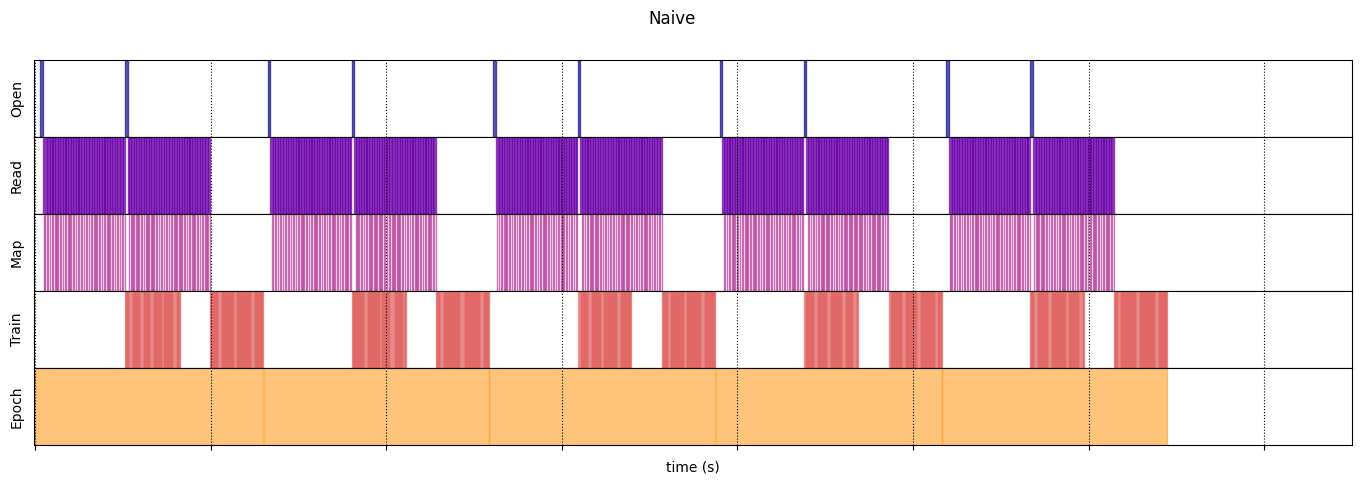

In [24]:
draw_timeline(naive_timeline, "Naive", 15)

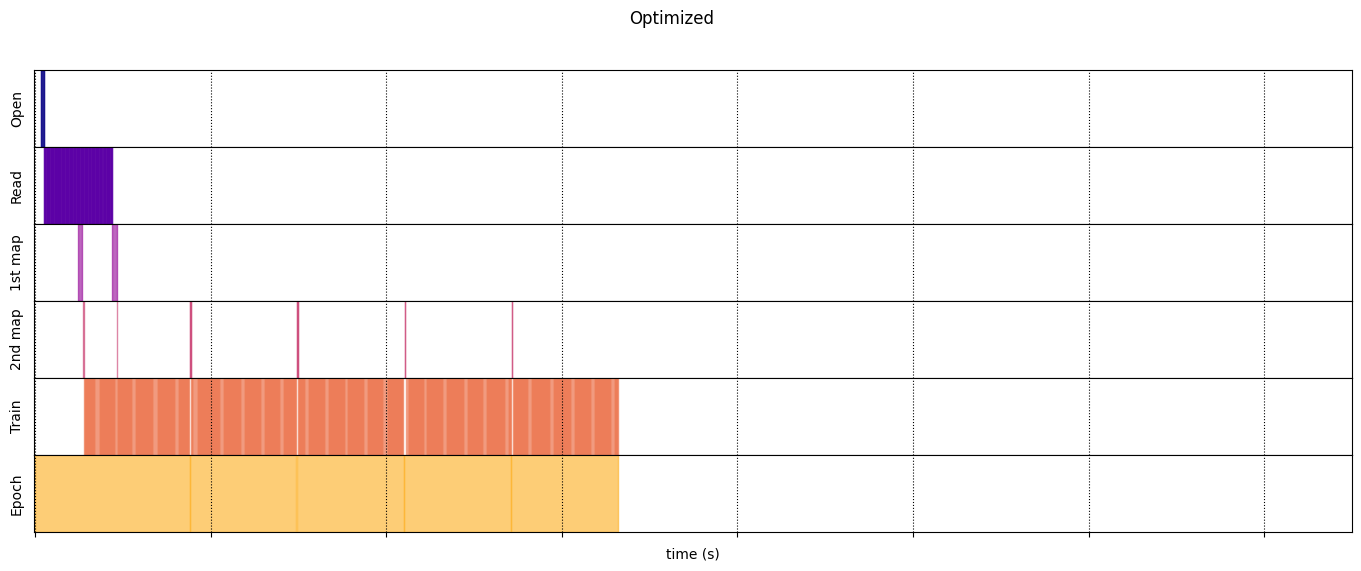

In [25]:
draw_timeline(optimized_timeline, "Optimized", 15)